In [74]:
from utils import *
import numpy as np
from scipy.signal import convolve2d

In [75]:
img = np.load('data_ps1.npz')
env = img['environment']
rod = img['rod']

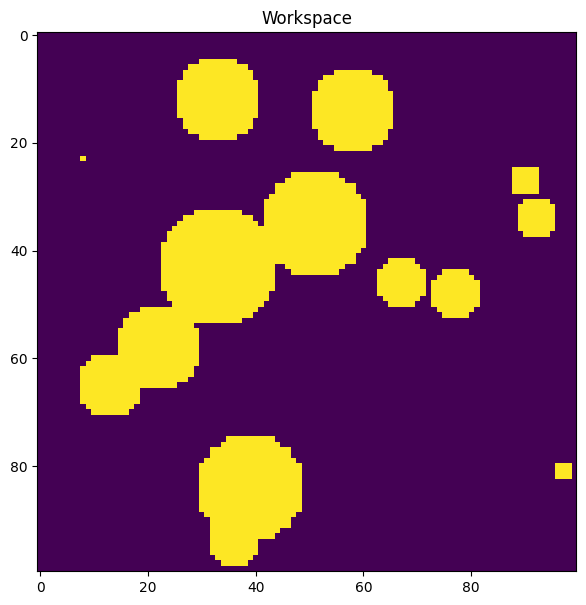

In [76]:
plt.figure(figsize=(14, 7))
plt.title("Workspace")
plt.imshow(env)
plt.show()

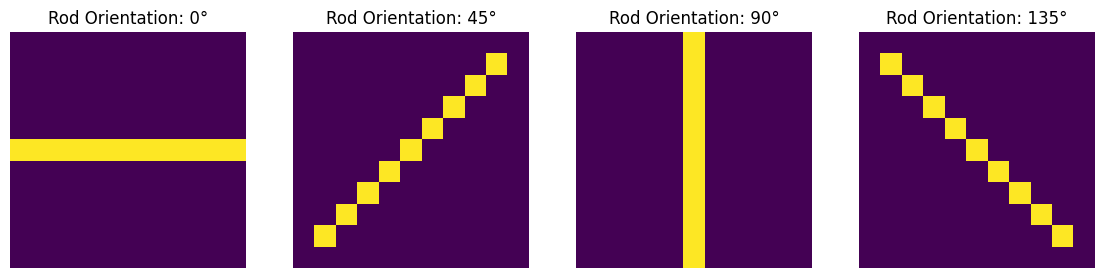

In [77]:
orientations = ["0°", "45°", "90°", "135°"]
fig, axs = plt.subplots(1, 4, figsize=(14, 7))
for i in range(4):
    axs[i].imshow(rod[:, :, i])
    axs[i].set_title(f"Rod Orientation: {orientations[i]}")
    axs[i].axis('off')
plt.show()

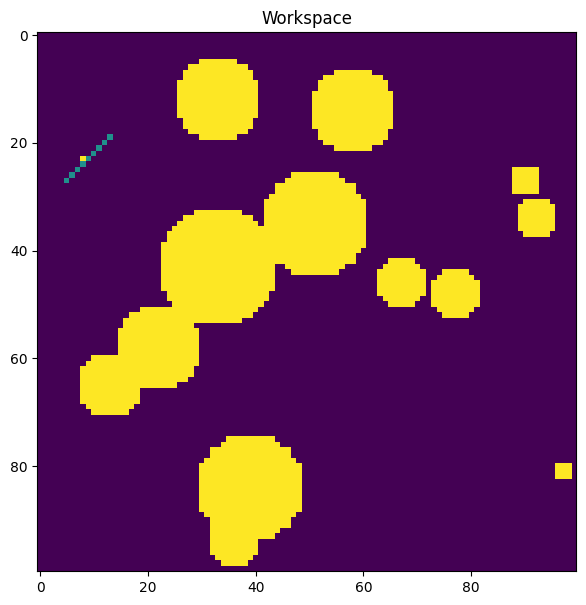

In [78]:
plt.figure(figsize=(14, 7))
plt.title("Workspace")
plt.imshow(plot_enviroment(img=env,obj=rod,state=(23,9,1)))
plt.show()

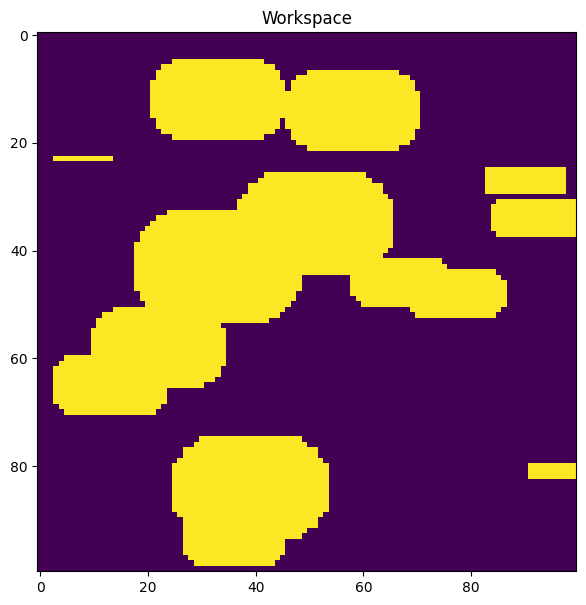

In [81]:
env_fix = normalize_image(convolve2d(in1=env,in2=rod[:, :, 0],boundary='symm', mode='same'))
plt.figure(figsize=(14, 7))
plt.title("Workspace")
plt.imshow(env_fix)
plt.show()